In [1]:
import psycopg2
conn = psycopg2.connect("dbname=postgres host=localhost port=55432 user=postgres")
cur = conn.cursor()
cur.execute("SELECT type, COUNT(id) FROM export.commits GROUP BY type")
cur.fetchall()

[('blamed_commit', 714L), ('fixing_commit', 1137L), ('other_commit', 349558L)]

2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:26,820 - __main__ - INFO - Started loading data
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
2017-04-14 20:09:27,182 - __main__ - INFO - Data loaded #840
Start extracting lines...
Completed extracting lines including #0 invalid patches.
{0: 0.49202795774039909}


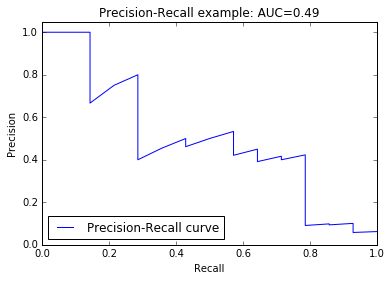

In [7]:
%matplotlib inline
import sys
from logging import getLogger, Formatter, StreamHandler, DEBUG
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn import cross_validation
import re
import math
import numpy as np
import scipy as sp
from scipy import sparse
import enum
from datetime import datetime
from vccf.line_extractor import LineExtractor
from vccf.logger import Logger
from unidiff.errors import UnidiffParseError

class Colum(enum.IntEnum):
    id = 1
    type = 3
    additions = 13
    deletions = 14
    past_different_authors = 18
    future_different_authors = 19
    author_contributions_percent = 20
    patch = 21
    hunk_count = 23
    files_changed = 25
    
def fetch(filename, key = None):
    npz = np.load(filename)
    key = npz.files[0] if key is None else key
    data = npz[key]
    npz.close()
    return data


logger = Logger.create(name=__name__)
logger.info('Started loading data')
data = fetch('var/vcc_sample_40x800.npz')
# data = fetch('var/vcc_data.npz')
logger.info('Data loaded #%d' % len(data))

patches = data[:, Colum.patch]
labels = data[:, Colum.type]

# Note: Be sure that unicode(patch, 'utf-8')
print 'Start extracting lines...'
cleansed_paches = [u''] * len(patches)
invalid_paches = []

matcher = r'(\d+)'
for index, patch in enumerate(patches):
    try:
#         patch = re.sub(matcher, logarithm, patch)
        cleansed_paches[index] = u' '.join(LineExtractor.extract_lines(patch.splitlines()))
    except UnidiffParseError as e:
        # @todo Recover 445 patches at total in vcc_data.npz
        invalid_paches.append((index, patch, e))

print 'Completed extracting lines including #%d invalid patches.' % len(invalid_paches)

# @TODO: stop_words=[]
vectorizer = CountVectorizer(min_df=2, stop_words=None)
vectorized = vectorizer.fit_transform(cleansed_paches) # csr_matrix
# feature_names = vectorizer.get_feature_names()
X = vectorized

# Now X is sparse csr_matrix looks like:
# [[0 0 0 ..., 0 0 0]
#  [0 0 0 ..., 0 0 0]
#  [0 0 0 ..., 0 0 0]
#  ..., 
#  [0 0 0 ..., 0 0 0]
#  [0 0 0 ..., 0 0 0]
#  [0 0 0 ..., 0 0 0]]

# Bind metrics from Git metadata
target_metrics = map(lambda n:n-1, [
    Colum.additions,
    Colum.deletions,
    Colum.past_different_authors,
    Colum.future_different_authors,
    Colum.author_contributions_percent,
    Colum.hunk_count,
    Colum.files_changed,
])
metrics_data = np.array([row[target_metrics] for row in data])

X2 = sparse.hstack((X, metrics_data.astype(float)))
y = is_vcc = (labels == 'blamed_commit')

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.5, random_state=0)

# Run classifier
weight = {0:1, 1:.01}
classifier = LinearSVC(C=1.0, class_weight=weight)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
precision[0], recall[0], _ = precision_recall_curve(y_test, y_score)
average_precision[0] = average_precision_score(y_test, y_score)

print average_precision

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.savefig("figure_%s" % datetime.now().strftime('%s'))

!osascript -e 'display notification "Done" with title "VCC-Note" sound name "Purr"'
# !open .